In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm


import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
from torch.nn.functional import max_pool1d


import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):
    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row)
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices

def label_array1_based_on_array2(array1, array2, threshold=5):
    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    sorted_array2 = np.sort(array2)
    
    labels = np.zeros(len(array1), dtype=int)
    
    for i, value in enumerate(array1):
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        if right_index > left_index:
            labels[i] = 1
    
    return labels


def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    windows = np.array(windows)
    return windows

In [3]:
all_labels = {}
all_sample_data = {}
for file in ['mouse6_021322_natural_image001.ns4', 
             'mouse6_022223_natural_image_001.ns4',
             'mouse6_022522_natural_image_001.ns4', 'mouse6_082322_natural_image_001.ns4',
             'mouse6_112022_natural_image_001.ns4']:
    date = file.split("_")[1]

    recording_raw = se.read_blackrock(file_path=f'/media/ubuntu/sda/data/mouse6/ns4/natural_image/{file}')
    recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
    recording_stimulated = recording_raw.channel_slice(['98'])

    recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
    recording_f = spre.common_reference(recording_f, reference="global", operator="median")

    data = recording_f.get_traces().astype("float32").T
    threshold_result = detect_local_maxima_in_window(data)
    threshold_result = np.array(threshold_result)
    valid_indices = threshold_result[(threshold_result > 30)]
    valid_indices = valid_indices[valid_indices < data.shape[1] - 31]
    spike_inf = pd.read_csv(f"/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/{date}/spike_inf.csv")
    removed_spikes = spike_inf['cluster'].value_counts()
    removed_spikes = removed_spikes[removed_spikes < 8000].index
    spike_inf = spike_inf[~spike_inf['cluster'].isin(removed_spikes)]
    labels = label_array1_based_on_array2(valid_indices, spike_inf['time'], threshold=1)

    import random
    num_samples = 50000
    indices = random.sample(range(len(valid_indices)), num_samples)
    all_labels[file] = labels[indices]
    all_sample_data[file] = extract_windows(data, np.array(valid_indices[indices]), window_size=61)

In [21]:
labels = []
for i in all_labels.values():
    labels.extend(i)

In [5]:
sample_date = []
for file in all_labels.keys():
    sample_date.extend([file] * len(all_labels[file]))

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [7]:
device = 'cuda'
model = torch.load("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/ANN_result/spike_detection.pth")
model = model.to(device)

In [8]:
results = {}
for i in all_sample_data.keys():
    x = torch.tensor(all_sample_data[i])
    x = x.to(device)
    x = x.reshape(-1, 61 * 30)
    x = model.fc1(x)
    x = model.relu1(x)
    x = model.fc2(x)
    x = model.relu2(x)
    results[i] = x.cpu().detach().numpy()

In [9]:
stacked_data = np.vstack(list(results.values()))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import random

pca = PCA(n_components=20)
pca_data = pca.fit_transform(stacked_data)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_data = umap_reducer.fit_transform(pca_data)

In [ ]:
unique_dates = np.unique(all_predictions)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_predictions]

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("modality_alignment.pdf") as pdf:
    labels = [str(i) for i in labels]
    unique_dates = np.unique(labels)
    color_map = {'0': '#ededed',
                 '1': 'orange'} 

    colors = [color_map[date] for date in labels]

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
    plt.title('GT Labels')
    plt.xticks([])
    plt.yticks([])
    pdf.savefig()
    plt.close()

    unique_dates = np.unique(sample_date)
    color_map = {date: plt.cm.tab10((i + 2) % 10) for i, date in enumerate(unique_dates)} 

    colors = [color_map[date] for date in sample_date]

    for i in range(len(unique_dates)):
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(umap_data[i * 50000: (i+1) * 50000, 0], umap_data[i * 50000: (i+1) * 50000, 1], color=colors[i * 50000: (i+1) * 50000], s=0.1, alpha=0.7)
        plt.title(unique_dates[i])
        pdf.savefig()
        plt.close()

Text(0, 0.5, 'UMAP 2')

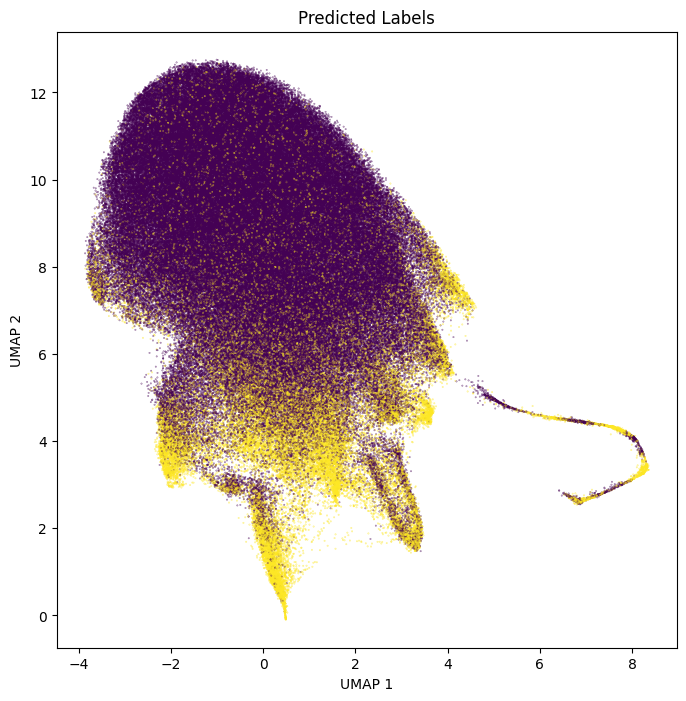

In [11]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=labels, s=0.1, alpha=0.7)
plt.title('Predicted Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

In [ ]:
unique_dates = np.unique(sample_date)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in sample_date]


Text(0, 0.5, 'UMAP 2')

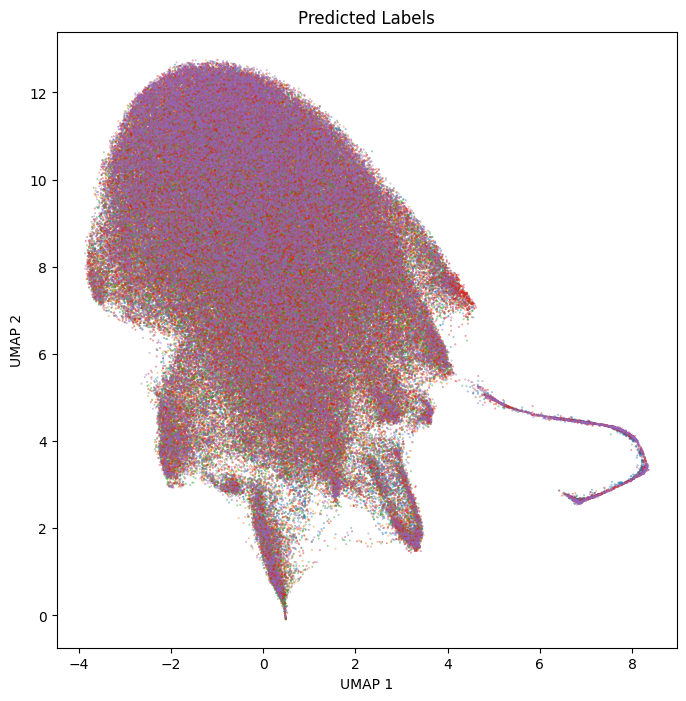

In [13]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], color=colors, s=0.1, alpha=0.7)
plt.title('Predicted Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')